## Libraries and Hyper-parameters

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as transforms


EPOCH = 1      
BATCH_SIZE = 32
TIME_STEP = 28           # input time step (image height)
INPUT_SIZE = 28          # input size (image width)
LR = 1e-2                
DOWNLOAD_MNIST = False   # if download the data

## Loading Dataset and Data Preprocessing

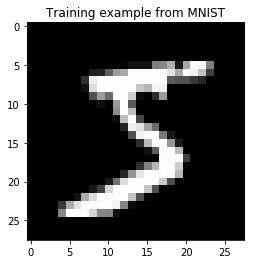

In [2]:
"""
*Mean substraction and normalization as data preprocessing:
   Note that the transforms.ToTensor() scale the data into range (0, 1), so the resulting mean and std dev will be .5
   and although MNIST images are grey scale, we still need to provide means and stddevs for 3 channels (RGB).
"""
data_prepro = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])


# Load the MNIST dataset: training and test data
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,
    transform=data_prepro,
    download=DOWNLOAD_MNIST
)

test_data = dsets.MNIST(root='./mnist/', 
                        train=False,
                        transform=data_prepro)

# Create data loader from the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

"""
We create two data loader for test data:
  1. We will examine the test accuracy as training goes along with 2,500 test data using test_loader
  2. Examine the test accuracy on the entire test data using test_loader2
"""
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=2500, 
                                          shuffle=True)

test_loader2 = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=len(test_data))


# Show one example
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('Training example from MNIST')
plt.show()

## Network, Loss and Optimizer

### Feedforward

In [3]:
fnn = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
print(fnn)

optim_fnn = torch.optim.Adam(fnn.parameters(), lr=LR)

Sequential (
  (0): Linear (784 -> 128)
  (1): ReLU ()
  (2): Linear (128 -> 10)
)


### LSTM

In [4]:
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
        )

        self.out = nn.Linear(128, 10)

        
    def forward(self, x):
        
        """
        1. "None" indicates zero initial hidden and cell state
        2. Discard the final hidden and cell state, don't need them for the output.
        3. Use the output of the LSTM layer at the *last* time-step.
        """
        output, (hidden, cell) = self.lstm(x, None)
        
        out = self.out(output[:, -1, :])
        
        return out

In [5]:
rnn = LSTM(); print(rnn)
optim_rnn = torch.optim.Adam(rnn.parameters(), lr=LR)   

LSTM (
  (lstm): LSTM(28, 128, batch_first=True)
  (out): Linear (128 -> 10)
)


### CNN

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        
        return output

In [7]:
cnn = CNN(); print(cnn)
optim_cnn = torch.optim.Adam(cnn.parameters(), lr=LR)

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)


In [8]:
# Share the same loss function across 3 networks
loss_func = nn.CrossEntropyLoss()

## Training

In [9]:
for epoch in range(EPOCH):

    for step, (X, y) in enumerate(train_loader):
        
        """
        Here we train the 3 types of networks simultaneously
        """
        
        # FNN forward/backward pass
        X1 = Variable(X.view(-1, 784))
        y1 = Variable(y)
        _y1 = fnn(X1)
        
        loss_fnn = loss_func(_y1, y1)
        optim_fnn.zero_grad()                   
        loss_fnn.backward()                         
        optim_fnn.step()
        
        # RNN forward/backward pass
        X2 = Variable(X.view(-1, 28, 28))  # squeeze the color channel, resulting shape (batch, time-step, input-size)
        y2 = Variable(y)                       
        _y2 = rnn(X2)
        
        loss_rnn = loss_func(_y2, y2)
        optim_rnn.zero_grad()                   
        loss_rnn.backward()                         
        optim_rnn.step()                        
        
        # CNN forward/backward pass
        X3 = Variable(X)
        y3 = Variable(y)
        _y3 = cnn(X3)
        
        loss_cnn = loss_func(_y3, y3)
        optim_cnn.zero_grad()                   
        loss_cnn.backward()                         
        optim_cnn.step()
        
        
        # Evaluate on 2,500 test data points to see progress
        if step % 50 == 0:
            
            for X, y in test_loader:
                
                """
                Test the 3 networks simultaneously
                """
                
                # Test FNN
                X1 = Variable(X.view(-1, 784))
                y1 = Variable(y)
                _y1 = fnn(X1)
                
                # Test RNN
                X2 = Variable(X.view(-1, 28, 28))
                y2 = Variable(y)                       
                _y2 = rnn(X2)
                
                # Test CNN
                X3 = Variable(X)
                y3 = Variable(y)
                _y3 = cnn(X3)
                
                # Calculate accuracy
                y1 = y1.data.numpy()
                y2 = y2.data.numpy()
                y3 = y3.data.numpy()
                
                # Extract predicted class
                _y1 = torch.max(_y1, 1)[1].data.numpy().squeeze()
                _y2 = torch.max(_y2, 1)[1].data.numpy().squeeze()
                _y3 = torch.max(_y3, 1)[1].data.numpy().squeeze()
                
                # Compute accuracies
                accu_fnn = (_y1 == y1).mean()
                accu_rnn = (_y2 == y2).mean()
                accu_cnn = (_y3 == y3).mean()
                
                break  # examine the test accuracy on 2,500 test data
            
            # Print epoch, mini-batch and test accuracies
            print('Epoch {0} Mini-batch {1}  \nFNN/RNN/CNN: {2:.2f}/{3:.2f}/{4:.2f}\n'.
                  format(epoch, step, accu_fnn, accu_rnn, accu_cnn))

            # If the accuracy is good enough, quit training
            if min(accu_fnn, accu_rnn, accu_cnn) > 0.85: break

Epoch 0 Mini-batch 0  
FNN/RNN/CNN: 0.10/0.10/0.10

Epoch 0 Mini-batch 50  
FNN/RNN/CNN: 0.85/0.22/0.92

Epoch 0 Mini-batch 100  
FNN/RNN/CNN: 0.81/0.49/0.94

Epoch 0 Mini-batch 150  
FNN/RNN/CNN: 0.87/0.66/0.96

Epoch 0 Mini-batch 200  
FNN/RNN/CNN: 0.80/0.74/0.96

Epoch 0 Mini-batch 250  
FNN/RNN/CNN: 0.90/0.78/0.96

Epoch 0 Mini-batch 300  
FNN/RNN/CNN: 0.88/0.83/0.96

Epoch 0 Mini-batch 350  
FNN/RNN/CNN: 0.89/0.85/0.94



## Evaluation

In [10]:
for X, y in test_loader2:
                
    """
    Test the 3 networks simultaneously
    """

    # Test FNN
    X1 = Variable(X.view(-1, 784))
    y1 = Variable(y)
    _y1 = fnn(X1)

    # Test RNN
    X2 = Variable(X.view(-1, 28, 28))
    y2 = Variable(y)                       
    _y2 = rnn(X2)
    
    # Test CNN
    X3 = Variable(X)
    y3 = Variable(y)
    _y3 = cnn(X3)

    # Calculate accuracy
    y1 = y1.data.numpy()
    y2 = y2.data.numpy()
    y3 = y3.data.numpy()

    # Extract predicted label
    _y1 = torch.max(_y1, 1)[1].data.numpy().squeeze()
    _y2 = torch.max(_y2, 1)[1].data.numpy().squeeze()
    _y3 = torch.max(_y3, 1)[1].data.numpy().squeeze()

    # Compute accuracies
    accu_fnn = (_y1 == y1).mean()
    accu_rnn = (_y2 == y2).mean()
    accu_cnn = (_y3 == y3).mean()

print('FNN/RNN/CNN: {0:.2f}/{1:.2f}/{2:.2f}'.format(accu_fnn, accu_rnn, accu_cnn))

FNN/RNN/CNN: 0.89/0.86/0.95
